<a href="https://colab.research.google.com/github/Deok-Hun/Aiffel_Kun/blob/master/EX_10_%EB%8B%A8%EC%96%B4_Level%EB%A1%9C_%EB%B2%88%EC%97%AD%EA%B8%B0_%EC%97%85%EA%B7%B8%EB%A0%88%EC%9D%B4%EB%93%9C%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.environ["HOME"]=""
print(os.getenv("HOME"))

In [3]:
import tensorflow

print(tensorflow.__version__)

2.9.2


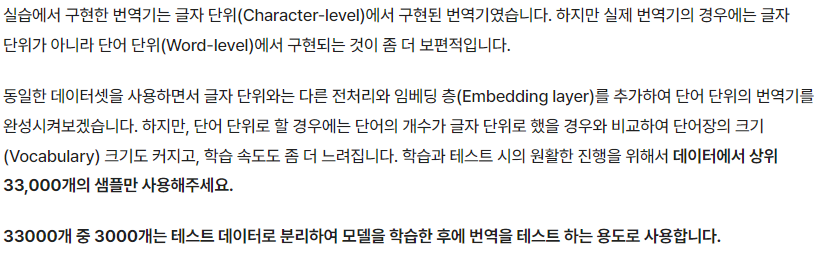

In [4]:
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [5]:
file_path = os.getenv('HOME')+'/content/drive/MyDrive/Exploration/Exploration_10/data/fra.txt'
lines = pd.read_csv(file_path, names=['eng','fra','cc'], sep = '\t')
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)  # 샘플 5개 출력

전체 샘플의 수 :  197463


,eng,fra,cc
58050,Is anybody else scared?,Qui que ce soit d'autre a-t-il peur ?,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
17150,You're careless.,Tu es négligente.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
9348,Who hired you?,Qui vous a recrutés ?,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
114826,You'll get used to it one day.,Vous vous y habituerez un jour.,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
13469,Don't come here.,Ne venez pas ici !,CC-BY 2.0 (France) Attribution: tatoeba.org #5...


In [6]:
lines = lines[['eng','fra']][:33000]   # 5만개 샘플 사용, ['cc']열 제외
lines.sample(5)

,eng,fra
5707,Pray for Tom.,Priez pour Tom.
12148,Tom is in luck.,Tom a de la chance.
32674,Tom is still alive.,Tom est toujours en vie.
16904,What's its name?,Quel est son nom ?
28136,You're too polite.,Vous êtes trop polis.


# Step 1~2. 정제, 정규화, 전처리(영어, 프랑스어 모두!)
  * 구두점(Punctuation)을 단어와 분리
  * 소문자로 바꾸기
  * 띄어쓰기 단위로 토큰을 수행
  * 디코더의 문장에 시작 토큰과 종료 토큰 넣기

In [7]:
import re

## 데이터 정제

In [8]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. 다시 양쪽 공백을 지웁니다


def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1. 소문자 & 양쪽 공백 지우기
    sentence = re.sub(r"([?.!,¿\'\":;@_-])", r" \1 ", sentence) # 2. 특수문자 양쪽에 공백 넣기
    sentence = re.sub(r'[" "]+', " ", sentence) # 3. 여러 공백을 하나의 공백으로 바꾸기
    sentence = sentence.strip() # 4. 다시 양쪽 공백 지우기
    
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

this @ _ is ; ; ; sample sentence .


## 데이터 전처리

In [9]:
# 시작 토큰과 종료 토큰 추가
sos_token = '<start>'   # start of sequence
eos_token = '<end>'   # end of sequence
lines.eng = lines.eng.apply(lambda x : preprocess_sentence(x))
lines.fra = lines.fra.apply(lambda x : '<start> ' + preprocess_sentence(x) + ' <end>')

print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 33000


,eng,fra
21474,we can ' t do that .,<start> nous ne pouvons pas le faire . <end>
7510,i outrank you .,<start> je vous dépasse . <end>
17031,you are a woman .,<start> vous êtes une femme . <end>
27133,we may never know .,<start> peut - être qu ' on ne le saura jamais...
24949,is his story true ?,<start> son histoire est - elle vraie ? <end>


# Step 3. 케라스의 토크나이저로 텍스트를 숫자로 바꿔보세요
  
  * 케라스 토크나이저를 사용해서 각 단어를 고유한 정수로 바꾸기
    * tokenizer.texts_to_sequences() 사용

In [10]:
import tensorflow as tf

## 영어 단어장 생성

In [11]:
# 영어 단어장
eng_tokenizer = Tokenizer(char_level=False, filters='')   # 문자 단위로 Tokenizer를 생성
eng_tokenizer.fit_on_texts(lines.eng)         # 50000개의 행을 가진 eng의 각 행에 토큰화를 수행

input_text = eng_tokenizer.texts_to_sequences(lines.eng)  # 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[29, 1], [29, 1], [29, 1]]

In [12]:
eng_tokenizer.word_index

{'.': 1,
 "'": 2,
 'i': 3,
 'you': 4,
 '?': 5,
 'tom': 6,
 'it': 7,
 'is': 8,
 's': 9,
 'a': 10,
 're': 11,
 'm': 12,
 'we': 13,
 't': 14,
 'the': 15,
 'that': 16,
 'he': 17,
 'was': 18,
 'me': 19,
 'this': 20,
 'they': 21,
 'are': 22,
 'to': 23,
 '!': 24,
 'do': 25,
 'can': 26,
 'my': 27,
 'your': 28,
 'go': 29,
 'have': 30,
 'not': 31,
 'don': 32,
 'll': 33,
 'be': 34,
 'she': 35,
 'no': 36,
 'did': 37,
 'what': 38,
 'all': 39,
 'let': 40,
 'here': 41,
 'like': 42,
 'in': 43,
 'get': 44,
 'up': 45,
 'how': 46,
 'very': 47,
 'on': 48,
 'need': 49,
 'one': 50,
 'want': 51,
 ',': 52,
 'him': 53,
 'out': 54,
 'love': 55,
 'come': 56,
 'who': 57,
 'please': 58,
 'us': 59,
 'there': 60,
 'just': 61,
 'know': 62,
 'now': 63,
 'stop': 64,
 'so': 65,
 'of': 66,
 'got': 67,
 'too': 68,
 'help': 69,
 'look': 70,
 'take': 71,
 'good': 72,
 'for': 73,
 'has': 74,
 'at': 75,
 'see': 76,
 'will': 77,
 'were': 78,
 've': 79,
 'keep': 80,
 'had': 81,
 'am': 82,
 'back': 83,
 'give': 84,
 'feel': 85,


## 프랑스어 단어장 생성

In [13]:
# 프랑스어 단어장
fra_tokenizer = Tokenizer(char_level=False, filters = ' ')
fra_tokenizer.fit_on_texts(lines.fra)

target_text = fra_tokenizer.texts_to_sequences(lines.fra)  # 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[1, 76, 10, 2], [1, 345, 3, 2], [1, 27, 486, 10, 2]]

In [14]:
# 단어장 크기를 변수로 저장해둔다.(dense 및 maxlen에 활용))
eng_vocab_size = len(eng_tokenizer.word_index)+1        # 0번 토큰을 고려하여 +1 한다.
fra_vocab_size = len(fra_tokenizer.word_index)+1

print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 4710
프랑스어 단어장의 크기 : 9462


In [15]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

In [16]:
print('전체 샘플의 수 :', len(lines))
print('영어 단어장의 크기 :', eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)
print('영어 문장의 최대 길이', max_eng_seq_len)
print('프랑스어 문장의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 33000
영어 단어장의 크기 : 4710
프랑스어 단어장의 크기 : 9462
영어 문장의 최대 길이 10
프랑스어 문장의 최대 길이 20


In [17]:
fra_tokenizer.word_index

{'<start>': 1,
 '<end>': 2,
 '.': 3,
 "'": 4,
 'je': 5,
 'est': 6,
 '-': 7,
 '?': 8,
 'tom': 9,
 '!': 10,
 'vous': 11,
 'pas': 12,
 'j': 13,
 'il': 14,
 'le': 15,
 'ai': 16,
 'de': 17,
 'nous': 18,
 'a': 19,
 'ne': 20,
 'suis': 21,
 'c': 22,
 'tu': 23,
 'l': 24,
 'un': 25,
 'la': 26,
 'en': 27,
 'à': 28,
 'ce': 29,
 'n': 30,
 'me': 31,
 'êtes': 32,
 'une': 33,
 'ça': 34,
 'que': 35,
 'les': 36,
 'moi': 37,
 'es': 38,
 'elle': 39,
 'd': 40,
 's': 41,
 ',': 42,
 'sont': 43,
 'ils': 44,
 'y': 45,
 'était': 46,
 'sommes': 47,
 't': 48,
 'm': 49,
 'fait': 50,
 'tout': 51,
 'elles': 52,
 'qui': 53,
 'des': 54,
 'mon': 55,
 'aime': 56,
 'te': 57,
 'toi': 58,
 'as': 59,
 'bien': 60,
 'très': 61,
 'été': 62,
 'se': 63,
 'du': 64,
 'ici': 65,
 'besoin': 66,
 'air': 67,
 'faire': 68,
 'avez': 69,
 'peux': 70,
 'ont': 71,
 'personne': 72,
 'avons': 73,
 'veux': 74,
 'votre': 75,
 'va': 76,
 'qu': 77,
 'cela': 78,
 'on': 79,
 'fais': 80,
 'étais': 81,
 'ton': 82,
 'faut': 83,
 'là': 84,
 'comment':

In [18]:
encoder_input = input_text

# 종료 토큰 제거 (디코더 입력)   -> 숫자 2 (<eos> 토큰)
decoder_input = [[char for char in line if char != fra_tokenizer.word_index[eos_token] ] for line in target_text]

# 시작 토큰 제거 (디코더 출력)   -> 숫자 1 (<sos> 토큰)
decoder_target = [[char for char in line if char != fra_tokenizer.word_index[sos_token] ] for line in target_text]

In [19]:
print(decoder_input[:3])
print(decoder_target[:3])

[[1, 76, 10], [1, 345, 3], [1, 27, 486, 10]]
[[76, 10, 2], [345, 3, 2], [27, 486, 10, 2]]


## 패딩 적용

In [20]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding = 'post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding = 'post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding = 'post')

print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (33000, 10)
프랑스어 입력데이터의 크기(shape) : (33000, 20)
프랑스어 출력데이터의 크기(shape) : (33000, 20)


In [21]:
print(encoder_input[0])

[29  1  0  0  0  0  0  0  0  0]


## train, test 분할

In [22]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :', np.shape(encoder_input_train))
print('프랑스어 학습 입력데이터의 크기(shape) :', np.shape(decoder_input_train))
print('프랑스어 학습 출력데이터의 크기(shape) :', np.shape(decoder_target_train))

영어 학습데이터의 크기(shape) : (30000, 10)
프랑스어 학습 입력데이터의 크기(shape) : (30000, 20)
프랑스어 학습 출력데이터의 크기(shape) : (30000, 20)


In [23]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 10)
(30000, 20)
(30000, 20)
(3000, 10)
(3000, 20)
(3000, 20)


# Step 4. 임베딩 층(Embedding layer) 사용하기

In [24]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

## 인코더 설계(train)

In [25]:
embedding_size = 512
hidden_size = 512

# 인코더 LSTM 셀의 마지막 time step의 hidden state와 cell state를 
# 디코더 LSTM의 첫 번째 hidden state와 cell state로 전달해준다.

# 입력 텐서 생성
encoder_inputs = Input(shape=(None, ))

# 임베딩층 사용
enc_emb =  Embedding(eng_vocab_size, embedding_size)(encoder_inputs)

# 마스킹 사용
enc_masking = Masking(mask_value=0.0)(enc_emb)

# hidden size가 512인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(hidden_size, dropout = 0.5, return_state=True)

# 디코더로 전달할 hidden state, cell state를 리턴, encoder_outputs는 사용하지 않음.
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장
encoder_states = [state_h, state_c]

## 디코더 설계(train) - 입력

In [26]:
# 디코더 입력 텐서 생성
decoder_inputs = Input(shape=(None, ))

# 디코더 임베딩 층 사용
dec_emb =  Embedding(fra_vocab_size, hidden_size)(decoder_inputs)

# 디코더 마스킹 사용
dec_masking = Masking(mask_value=0.0)(dec_emb)

# hidden size가 512인 인코더의 LSTM 셀 생성
decoder_lstm = LSTM(hidden_size, dropout = 0.5, return_sequences = True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(dec_masking, initial_state = encoder_states)
# initial_state는 LSTM 셀의 초기 상태를 정의하는 인자이다.

## 디코더 설계(train) - 출력

In [27]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')  # 덴스는 단어장 크기로 지정
decoder_outputs = decoder_softmax_layer(decoder_outputs)

# Step 5. 모델 구현하기

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 한다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태이다. 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy가 아니라 sparse_categorical_crossentropy를 사용하여야 한다.

In [28]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 512)    2411520     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 512)    4844544     ['input_2[0][0]']                
                                                                                              

In [29]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train,
                    validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
                    batch_size = 128, epochs = 50)

Epoch 1/50
235/235 [==============================] - 27s 63ms/step - loss: 1.4440 - val_loss: 1.3054
Epoch 2/50
235/235 [==============================] - 12s 51ms/step - loss: 0.9525 - val_loss: 1.1294
Epoch 3/50
235/235 [==============================] - 12s 52ms/step - loss: 0.8387 - val_loss: 1.0543
Epoch 4/50
235/235 [==============================] - 12s 52ms/step - loss: 0.7623 - val_loss: 1.0092
Epoch 5/50
235/235 [==============================] - 12s 51ms/step - loss: 0.7003 - val_loss: 0.9731
Epoch 6/50
235/235 [==============================] - 12s 52ms/step - loss: 0.6492 - val_loss: 0.9499
Epoch 7/50
235/235 [==============================] - 12s 50ms/step - loss: 0.6061 - val_loss: 0.9159
Epoch 8/50
235/235 [==============================] - 12s 51ms/step - loss: 0.5687 - val_loss: 0.9050
Epoch 9/50
235/235 [==============================] - 12s 51ms/step - loss: 0.5362 - val_loss: 0.8900
Epoch 10/50
235/235 [==============================] - 12s 51ms/step - loss: 0.506

In [30]:
history_dict=history.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'val_loss'])


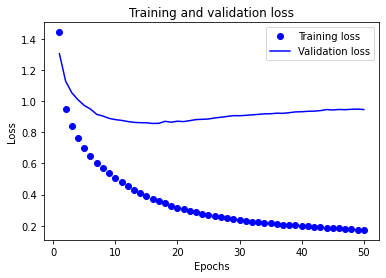

In [33]:
import matplotlib.pyplot as plt

loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(val_loss) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 인코더 설계(test)

In [34]:
# 인코더 설계시 생성했던 encoder_inputs(=입력 텐서)(encoder_inputs = Input(shape=(None, eng_vocab_size)))와
# hidden state와 cell state를 다음 time step으로 전달하기 위해 별도 저장했던 encoder_states(encoder_states = [state_h, state_c])를 재사용한다.

encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 512)         2411520   
                                                                 
 masking (Masking)           (None, None, 512)         0         
                                                                 
 lstm (LSTM)                 [(None, 512),             2099200   
                              (None, 512),                       
                              (None, 512)]                       
                                                                 
Total params: 4,510,720
Trainable params: 4,510,720
Non-trainable params: 0
_________________________________________________________________


## 디코더 설계(test)

In [36]:
# 이전 time step의 hidden state를 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))

# 이전 time step의 cell state를 저장하는 텐서
decoder_state_input_c = Input(shape=(hidden_size,))

# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
# decoder_states_inputs를 현재 time step의 초기 상태로 사용.
# 구체적인 동작 자체는 def decode_sequence()에 구현.
dec_emb_test =  Embedding(fra_vocab_size, hidden_size)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(dec_emb_test, initial_state = decoder_states_inputs)

# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states = [state_h, state_c]

In [37]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs = [decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 512)    4844544     ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 512)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 512)]        0           []                               
                                                                                            

In [38]:
# 먼저 만들어 두었던 사전을 간단한 변수로 다시 정의
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

# Step 6. 모델 평가하기

In [52]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = fra2idx['<start>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<end>' or
        len(decoded_sentence) > max_fra_seq_len):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

In [53]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + idx2eng[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != fra2idx['<start>'] and encoded_word != fra2idx['<end>']):
      sentence = sentence + idx2fra[encoded_word] + ' '
  return sentence

In [57]:
import numpy as np
# 입력 문장의 인덱스
for seq_index in [111, 222, 333, 444, 555]:
  input_seq = encoder_input[seq_index: seq_index+1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

1/1 [==============================] - 0s 41ms/step
입력문장 : i left . 
정답문장 : je suis partie . 
번역문장 : je suis partie 
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : come on . 
정답문장 : venez  ! 
번역문장 : allez ! ! ! ! . . .
--------------------------------------------------
1/1 [==============================] - 0s 19ms/step
입력문장 : i stood . 
정답문장 : je me suis tenue debout . 
번역문장 : je me me . . un 
--------------------------------------------------
1/1 [==============================] - 0s 20ms/step
입력문장 : you run . 
정답문장 : tu cours . 
번역문장 : tu . . . . . à 
--------------------------------------------------
1/1 [==============================] - 0s 16ms/step
입력문장 : go ahead ! 
정답문장 : avance ! 
번역문장 : allez - ! ! ! ! 
--------------------------------------------------
